# **Imports**

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import inspect
from scipy import linalg
import math
from tqdm import tqdm

# **Loading videos and images**

In [2]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	fps = cap.get(cv2.CAP_PROP_FPS)
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames,fps

In [3]:
def write_video(file_path, frames, fps):
    h, w = np.array(frames[0]).shape[0], np.array(frames[0]).shape[1]
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))
    for frame in frames:
        writer.write(frame)
    writer.release()

In [4]:
original_frames,fps1 = loadVid("/content/drive/MyDrive/asg2_cv/book.mov")
movie_frames,fps2 = loadVid("/content/drive/MyDrive/asg2_cv/ar_source.mov")
cover = cv2.imread("/content/drive/MyDrive/asg2_cv/cv_cover.jpg")

In [5]:
print(f"fps for original video = {fps1}")
print(f"fps for movie video = {fps2}")

fps for original video = 30.0
fps for movie video = 25.0


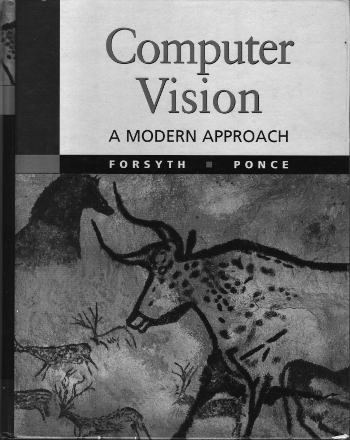

In [6]:
cv2_imshow(cover)

In [7]:
print(f"Length of original video: {len(original_frames)}")
print(f"Length of overlay video: {len(movie_frames)}")

Length of original video: 641
Length of overlay video: 511


# **SIFT Descriptor**

In [8]:
def sift(image):
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  sift = cv2.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(gray_image, None)
  sift_image = cv2.drawKeypoints(image, keypoints, 0)
  return sift_image, keypoints, descriptors

In [9]:
sift_image1, keypoints1, descriptors1 = sift(cover)
sift_image2, keypoints2, descriptors2 = sift(original_frames[0])

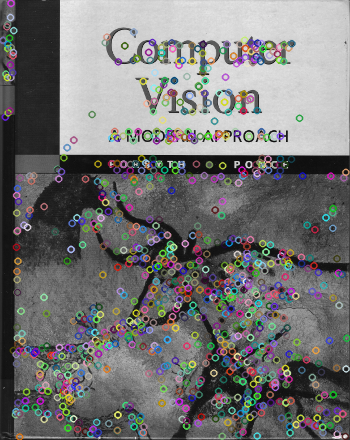

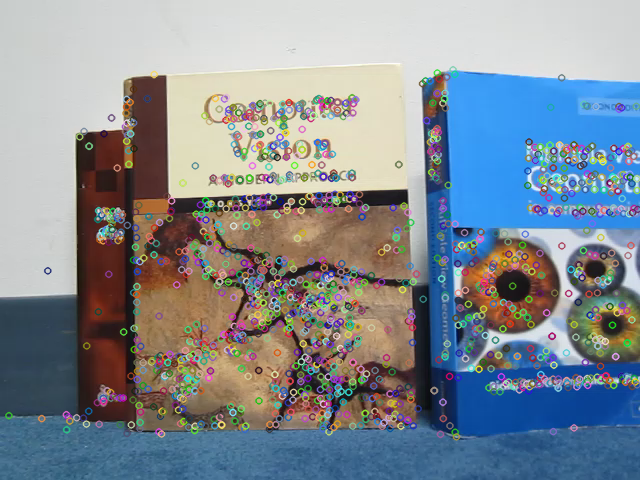

In [10]:
cv2_imshow(sift_image1)
cv2_imshow(sift_image2)

# **Key Matching**

In [54]:
def key_matching(descriptors1, descriptors2, nkp=50):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    #print(f"Number of matches before filtering = {len(matches)}")
    ratios = []
    for (i,j) in matches:
      ratios.append((i, i.distance/j.distance))
    ratios = sorted(ratios,key=lambda x:x[1])[0:nkp]
    final_matches = [x[0] for x in ratios]
    #print(f"Number of matches after filtering = {len(final_matches)}")
    final_matches = sorted(final_matches, key=lambda x:x.distance)
    return final_matches

In [12]:
matches = key_matching(descriptors1, descriptors2)
matched_img = cv2.drawMatches(cover, keypoints1, original_frames[0], keypoints2, matches, 0, flags=2)

Number of matches before filtering = 1205
Number of matches after filtering = 50


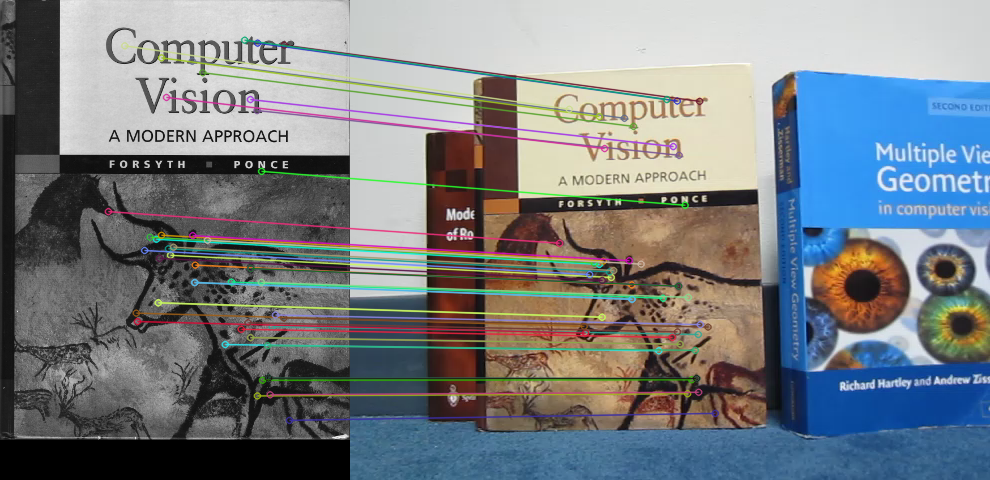

In [13]:
cv2_imshow(matched_img)

# **Homography Matrix**

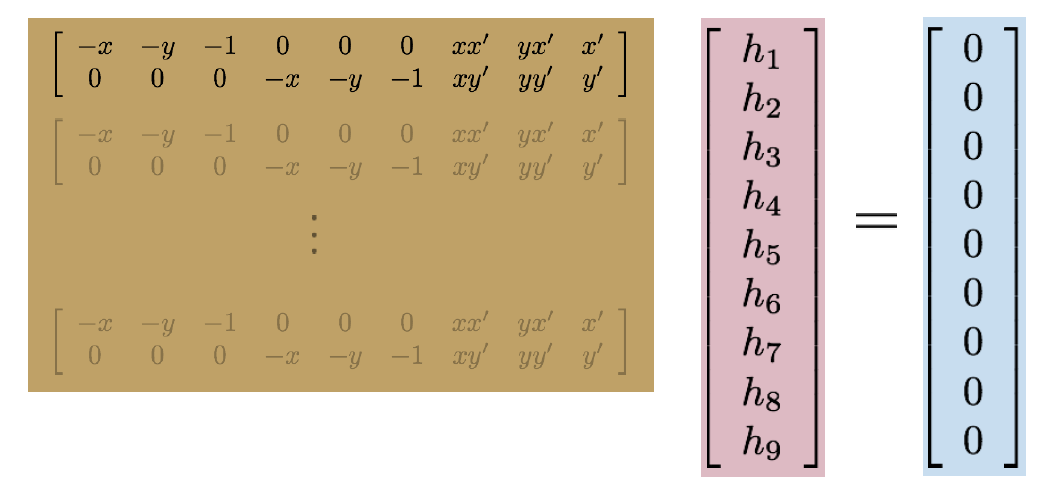

In [14]:
def get_kp(matches):
  image1_points=[]
  image2_points=[]
  for m in matches:
    i = m.queryIdx
    j = m.trainIdx
    image1_points.append(keypoints1[i].pt)
    image2_points.append(keypoints2[j].pt)
  return image1_points, image2_points

In [15]:
def constructA(image1_points,image2_points,start=0,end=50):
  A = np.zeros(((end-start)*2,9))
  for i in range(0,(end-start)*2,2):
    (x1,y1) = image1_points[i//2]
    (x2,y2) = image2_points[i//2]
    A[i] = np.array([-1*x1,-1*y1,-1,0,0,0,x1*x2,y1*x2,x2])
    A[i+1] = np.array([0,0,0,-1*x1,-1*y1,-1,x1*y2,y1*y2,y2])
  return A

In [16]:
def get_homography(A):
  U, s, Vh = linalg.svd(A)
  H = Vh[-1,:] / Vh[-1,-1]
  H = H.reshape(3, 3)
  return H

In [17]:
def get_new_points(points, H):
  new_points =[]
  for original_point in points:
    point = original_point.copy()
    point.append(1)
    point = np.array(point)
    point = point[...,np.newaxis]
    new_point = H @ point
    new_point = new_point/new_point[-1]
    new_points.append(new_point.T)
  new_points = np.array(new_points)[:,:,0:2]
  new_points = new_points.squeeze()
  return new_points

In [18]:
def builtin_check(matches,H,point):
  image1_points2, image2_points2 = get_kp(matches)
  h, status = cv2.findHomography(np.array(image1_points2), np.array(image2_points2))
  transformedPoint1 = H @ np.array(point).transpose()
  transformedPoint1 /= transformedPoint1[-1]
  transformedPoint2 = h @ np.array(point).transpose()
  transformedPoint2 /= transformedPoint2[-1]
  print(f"Our function: {transformedPoint1}")
  print(f"Built-in function: {transformedPoint2}")
  if sum(abs(transformedPoint1-transformedPoint2))/2 <1:
    print("Acceptable Range")
  else:
    print("Too far off!")
  if len(h[abs(h - H) >20])==0:
    print("Almost no difference")
    return True
  return False

In [19]:
def draw_frame(img, corners):
  copy_image = img.copy()
  corner_points = [(i,j) for i,j in np.round(corners).astype('int64')]
  copy_image = cv2.line(copy_image, corner_points[0],corner_points[1], (255, 0, 0) , 1, cv2.LINE_AA)
  copy_image = cv2.line(copy_image, corner_points[0], corner_points[2], (255, 0, 0) , 1, cv2.LINE_AA)
  copy_image = cv2.line(copy_image, corner_points[2], corner_points[3], (255, 0, 0) , 1, cv2.LINE_AA)
  copy_image = cv2.line(copy_image, corner_points[1], corner_points[3], (255, 0, 0) , 1, cv2.LINE_AA)
  return copy_image

In [20]:
def overlay(overlay_image, original_image, H):
  indices = [[i,j] for i in range(overlay_image.shape[1]) for j in range(overlay_image.shape[0])]
  new_points = get_new_points(indices,H)
  copy_image = original_image.copy()
  for i,(x,y) in enumerate(new_points):
    [x2,y2] = indices[i]
    if round(x) < original_image.shape[1] and round(y) < original_image.shape[0] and round(x) > 0 and round(y) > 0:
      copy_image[round(y),round(x)] = overlay_image[y2,x2]
  return copy_image

In [21]:
image1_points , image2_points = get_kp(matches)
A =constructA(image1_points,image2_points)
H = get_homography(A)

In [22]:
builtin_check(matches, H, [100,100,1])

Our function: [200.46777862 153.06750905   1.        ]
Built-in function: [200.43774218 153.02489693   1.        ]
Acceptable Range
Almost no difference


True

In [23]:
corners = [[0,0],[cover.shape[1]-1,0],[0,cover.shape[0]-1],[cover.shape[1]-1,cover.shape[0]-1]]
new_corners = get_new_points(corners, H)

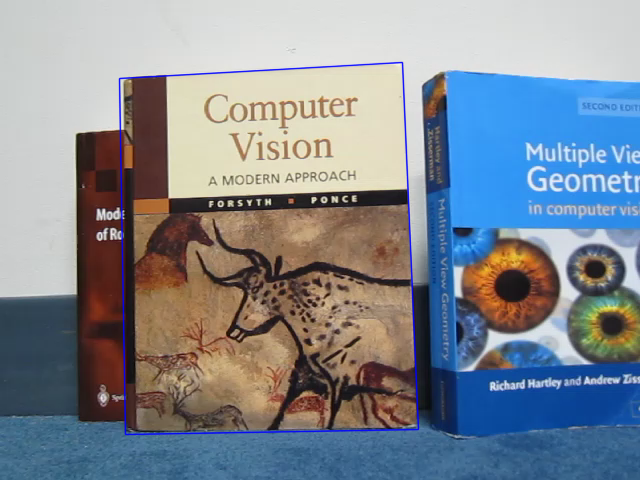

In [24]:
copy_image = draw_frame(original_frames[0],new_corners)
cv2_imshow(copy_image)

Number of matches before filtering = 1205
Number of matches after filtering = 300
Our Function


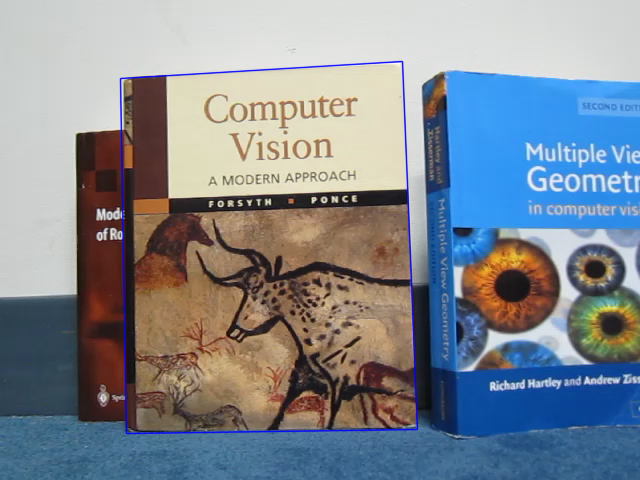

Built-in Function


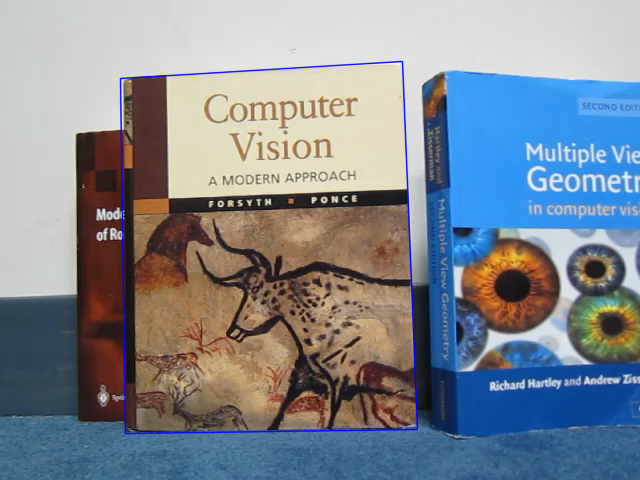

In [25]:
i = 0
sift_image1, keypoints1, descriptors1 = sift(cover)
sift_image2, keypoints2, descriptors2 = sift(original_frames[i])
matches = key_matching(descriptors1, descriptors2,nkp=300)
image1_points , image2_points = get_kp(matches)
A =constructA(image1_points,image2_points,start=0,end=15)
H = get_homography(A)
h, status = cv2.findHomography(np.array(image1_points)[0:15], np.array(image2_points)[0:15])
corners = [[0,0],[cover.shape[1]-1,0],[0,cover.shape[0]-1],[cover.shape[1]-1,cover.shape[0]-1]]
new_corners = get_new_points(corners, H)
new_corners2 = get_new_points(corners, h)
copy_image = draw_frame(original_frames[i],new_corners)
print("Our Function")
cv2_imshow(copy_image)
copy_image = draw_frame(original_frames[i],new_corners2)
print("Built-in Function")
cv2_imshow(copy_image)

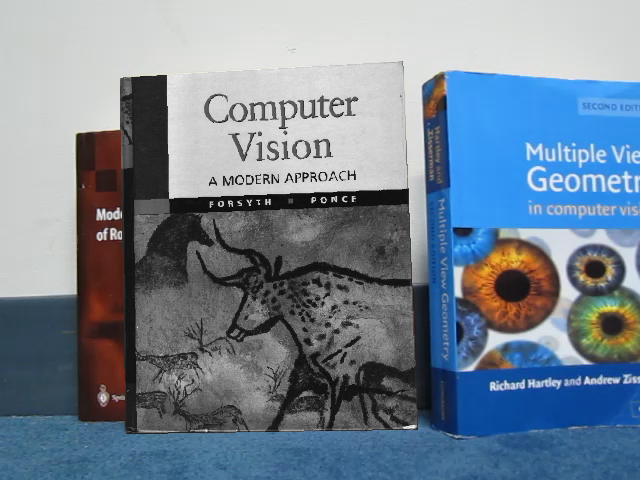

In [26]:
copy_image = overlay(cover,original_frames[0],H)
cv2_imshow(copy_image)

# **Saving video of all frames with the book outlined**

In [338]:
sift_image1, keypoints1, descriptors1 = sift(cover)
corners = [[0,0],[cover.shape[1]-1,0],[0,cover.shape[0]-1],[cover.shape[1]-1,cover.shape[0]-1]]
frames_stack = []
for i in tqdm(range(original_frames.shape[0])):
  sift_image2, keypoints2, descriptors2 = sift(original_frames[i])
  matches = key_matching(descriptors1, descriptors2,nkp=300)
  image1_points , image2_points = get_kp(matches)
  A =constructA(image1_points,image2_points,start=0,end=15)
  H = get_homography(A)
  new_corners = get_new_points(corners, H)
  copy_image = draw_frame(original_frames[i],new_corners)
  frames_stack.append(copy_image)

100%|██████████| 641/641 [02:33<00:00,  4.18it/s]


In [339]:
write_video("/content/drive/MyDrive/asg2_cv/output_outline.mov",frames_stack,fps1)

# **Cropping Movie Frame and Overlaying it on Original Video**

In [28]:
print(f"Cover Dimensions: {cover.shape}")
print(f"Movie Frame Dimensions: {movie_frames[0].shape}")
print(f"Original Video Frame Dimensions: {original_frames[0].shape}")

Cover Dimensions: (440, 350, 3)
Movie Frame Dimensions: (360, 640, 3)
Original Video Frame Dimensions: (480, 640, 3)


In [29]:
def center_frames(movie_frame,frame_shape,corners):
  ratio = frame_shape[0]/movie_frame.shape[0]
  copy_frame = cv2.resize(movie_frame, (round(movie_frame.shape[1]*ratio),round(movie_frame.shape[0]*ratio)))
  midpoint1 = (corners[0] + corners[1])/2
  midpoint2 = (corners[2] + corners[3])/2
  midpoint = (midpoint1+midpoint2)//2
  center = [copy_frame.shape[1]//2,copy_frame.shape[0]//2]
  translation = -1*midpoint + center
  black = np.zeros(copy_frame.shape)
  for i in range(black.shape[0]):
    if i+translation[1] < copy_frame.shape[0]:
      black[i,:,:] = copy_frame[i+round(translation[1]),:,:]
  for j in range(black.shape[1]):
    if j+translation[0] < black.shape[1]:
      black[:,j,:] = black[:,j+round(translation[0]),:]
  output = black[:,0:frame_shape[1],:]
  return output

In [30]:
def check_if_inside(corners,point):
  p1,p2,p3,p4 = corners
  #down
  if (((p2[1]-p1[1])/(p2[0]-p1[0])) - ((p1[1]-point[1])/(p1[0]-point[0])) <=0 and point[0]>=p1[0]) or (((p2[1]-p1[1])/(p2[0]-p1[0])) - ((p1[1]-point[1])/(p1[0]-point[0])) >=0 and point[0]<=p1[0]):
    #left
    if (round(p1[0]) == round(p3[0]) and point[0] >= round(p1[0])) or (((p3[1]-p1[1])/(p3[0]-p1[0])) - ((p1[1]-point[1])/(p1[0]-point[0])) >=0 and point[0]>=p1[0] and p3[0]>p1[0]) or (((p3[1]-p1[1])/(p3[0]-p1[0])) - ((p1[1]-point[1])/(p1[0]-point[0])) <=0 and point[0]>=p1[0] and p3[0]<p1[0]):
      #up
      if ((p4[1]-p3[1])/(p4[0]-p3[0])) - ((p4[1]-point[1])/(p4[0]-point[0])) <=0 and point[0]<=p4[0]:
        #right
        if (round(p2[0]) == round(p4[0]) and point[0] <= round(p2[0])) or (((p4[1]-p2[1])/(p4[0]-p2[0])) - ((p4[1]-point[1])/(p4[0]-point[0])) >=0):
          return True

  return False

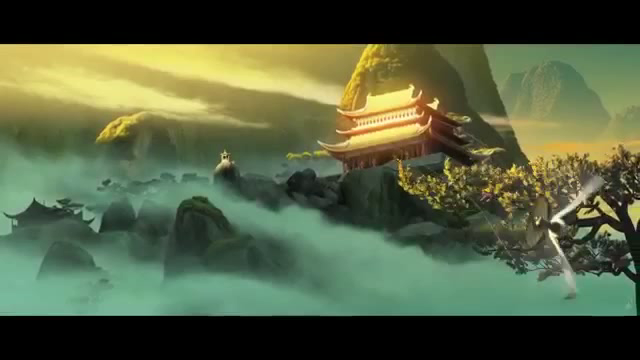

In [31]:
cv2_imshow(movie_frames[0])

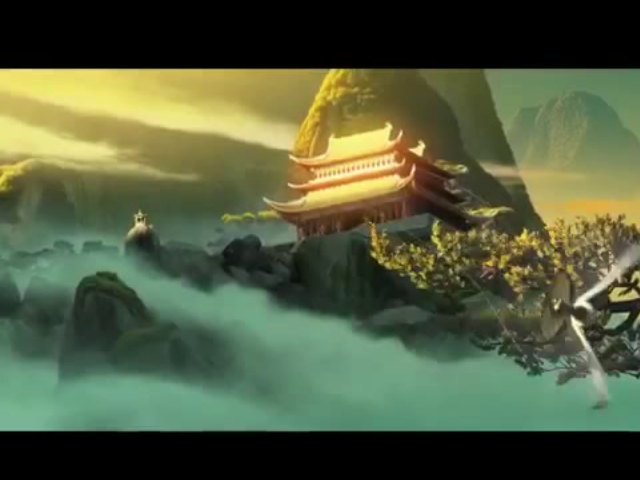

In [32]:
centered_frame = center_frames(movie_frames[0],original_frames[0].shape,new_corners)
cv2_imshow(centered_frame)

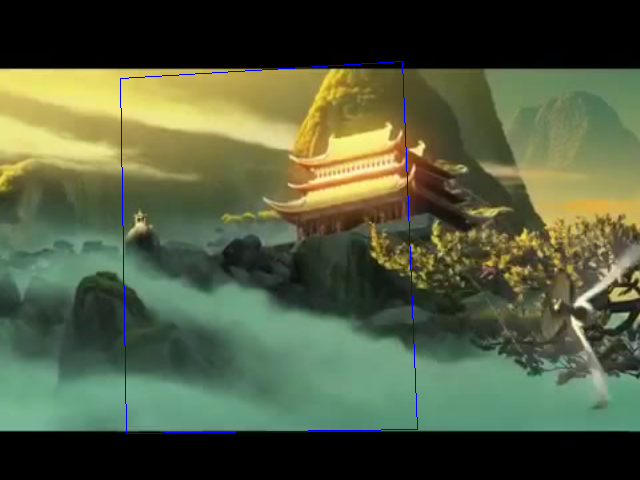

In [32]:
copy = draw_frame(centered_frame,new_corners)
cv2_imshow(copy)

In [51]:
def overlay_without_homography(original_frame, movie_frame, corners):
  copy = original_frame.copy()
  indices = np.array([[j,k] for k in range(original_frame.shape[0]) for j in range(original_frame.shape[1])])
  boolean = [check_if_inside(corners,x) for x in indices]
  filtered_indices = np.flip(indices[boolean],axis=1)
  for index in filtered_indices:
    copy[index[0]][index[1]] = movie_frame[index[0]][index[1]]
  return copy

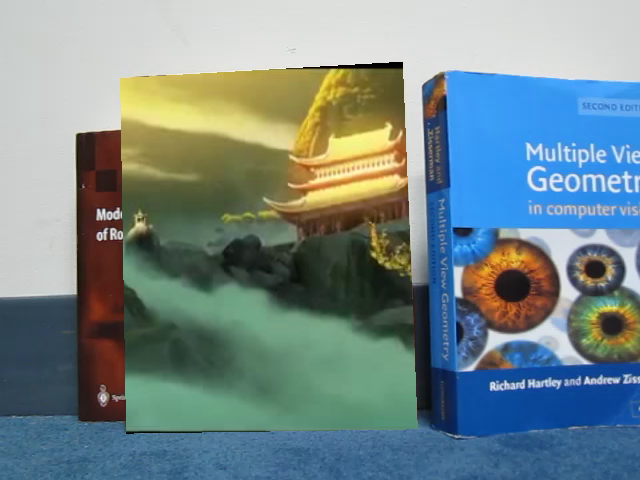

In [52]:
final_frame = overlay_without_homography(original_frames[0],centered_frame,new_corners)
cv2_imshow(final_frame)

# **Saving output without homography**

In [59]:
sift_image1, keypoints1, descriptors1 = sift(cover)
corners = [[0,0],[cover.shape[1]-1,0],[0,cover.shape[0]-1],[cover.shape[1]-1,cover.shape[0]-1]]
frames_stack = []
for i in tqdm(range(original_frames.shape[0])):
  if i < movie_frames.shape[0]:
    sift_image2, keypoints2, descriptors2 = sift(original_frames[i])
    matches = key_matching(descriptors1, descriptors2,nkp=300)
    image1_points , image2_points = get_kp(matches)
    A =constructA(image1_points,image2_points,start=0,end=15)
    H = get_homography(A)
    new_corners = get_new_points(corners, H)
    centered_frame = center_frames(movie_frames[i],original_frames[i].shape,new_corners)
    final_frame = overlay_without_homography(original_frames[i],centered_frame,new_corners)
  else:
    final_frame = original_frames[i]
  frames_stack.append(final_frame)

100%|██████████| 641/641 [52:57<00:00,  4.96s/it]


In [60]:
write_video("/content/drive/MyDrive/asg2_cv/output_without_homography.mov",frames_stack,fps1)

# **Saving output with homography**

In [121]:
def crop_center(image, reference):
  img_copy = image.copy()
  img_copy = cv2.resize(img_copy, (round(img_copy.shape[1]*reference.shape[0]/img_copy.shape[0]),reference.shape[0]))
  center = (img_copy.shape[0]//2,img_copy.shape[1]//2)
  img_copy  = img_copy[:,center[1]-reference.shape[1]//2:center[1]+reference.shape[1]//2]
  return img_copy

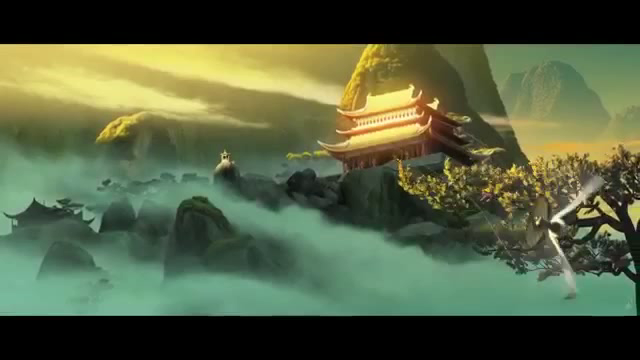

In [70]:
cv2_imshow(movie_frames[0])

In [122]:
cv2_imshow(crop_center(movie_frames[0],cover))

In [125]:
sift_image1, keypoints1, descriptors1 = sift(cover)
corners = [[0,0],[cover.shape[1]-1,0],[0,cover.shape[0]-1],[cover.shape[1]-1,cover.shape[0]-1]]
frames_stack = []
for i in tqdm(range(original_frames.shape[0])):
  if i < movie_frames.shape[0]:
    sift_image2, keypoints2, descriptors2 = sift(original_frames[i])
    matches = key_matching(descriptors1, descriptors2,nkp=300)
    image1_points , image2_points = get_kp(matches)
    A =constructA(image1_points,image2_points,start=0,end=15)
    H = get_homography(A)
    final_frame = overlay(crop_center(movie_frames[i],cover),original_frames[i],H)
  else:
    final_frame = original_frames[i]
  frames_stack.append(final_frame)

100%|██████████| 641/641 [30:29<00:00,  2.85s/it]


In [126]:
write_video("/content/drive/MyDrive/asg2_cv/output_with_homography.mov",frames_stack,fps1)

# **Cropping the black parts in the video and comparing results**

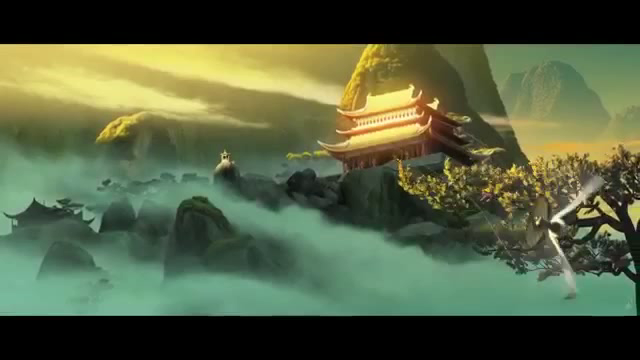

In [128]:
cv2_imshow(movie_frames[0])

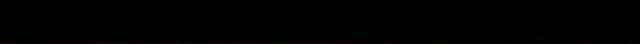

In [136]:
cv2_imshow(movie_frames[0][0:44])

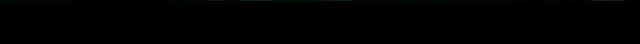

In [151]:
cv2_imshow(movie_frames[0][316:])

In [152]:
cv2_imshow(movie_frames[0][44:317])

## **Saving output without homography**

In [153]:
sift_image1, keypoints1, descriptors1 = sift(cover)
corners = [[0,0],[cover.shape[1]-1,0],[0,cover.shape[0]-1],[cover.shape[1]-1,cover.shape[0]-1]]
frames_stack = []
for i in tqdm(range(original_frames.shape[0])):
  if i < movie_frames.shape[0]:
    sift_image2, keypoints2, descriptors2 = sift(original_frames[i])
    matches = key_matching(descriptors1, descriptors2,nkp=300)
    image1_points , image2_points = get_kp(matches)
    A =constructA(image1_points,image2_points,start=0,end=15)
    H = get_homography(A)
    new_corners = get_new_points(corners, H)
    centered_frame = center_frames(movie_frames[i][44:317],original_frames[i].shape,new_corners)
    final_frame = overlay_without_homography(original_frames[i],centered_frame,new_corners)
  else:
    final_frame = original_frames[i]
  frames_stack.append(final_frame)

100%|██████████| 641/641 [52:45<00:00,  4.94s/it]


In [154]:
write_video("/content/drive/MyDrive/asg2_cv/output_without_homography_cropped.mov",frames_stack,fps1)

## **Saving output with homography**

In [155]:
sift_image1, keypoints1, descriptors1 = sift(cover)
corners = [[0,0],[cover.shape[1]-1,0],[0,cover.shape[0]-1],[cover.shape[1]-1,cover.shape[0]-1]]
frames_stack = []
for i in tqdm(range(original_frames.shape[0])):
  if i < movie_frames.shape[0]:
    sift_image2, keypoints2, descriptors2 = sift(original_frames[i])
    matches = key_matching(descriptors1, descriptors2,nkp=300)
    image1_points , image2_points = get_kp(matches)
    A =constructA(image1_points,image2_points,start=0,end=15)
    H = get_homography(A)
    final_frame = overlay(crop_center(movie_frames[i][44:317],cover),original_frames[i],H)
  else:
    final_frame = original_frames[i]
  frames_stack.append(final_frame)

100%|██████████| 641/641 [30:22<00:00,  2.84s/it]


In [156]:
write_video("/content/drive/MyDrive/asg2_cv/output_with_homography_cropped.mov",frames_stack,fps1)